In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd
import pyperclip

In [101]:
dt = 0.100
s  = ctl.TransferFunction.s

C = 0.394784176043574/(1.0*s**2 + 0.888576587631673*s + 0.394784176043574)
C

TransferFunction(array([0.39478418]), array([1.        , 0.88857659, 0.39478418]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [102]:
C_z = ctl.c2d(C, dt, method='tustin')
C_z

TransferFunction(array([0.00094408, 0.00188817, 0.00094408]), array([ 1.        , -1.91122623,  0.91500257]), 0.1)

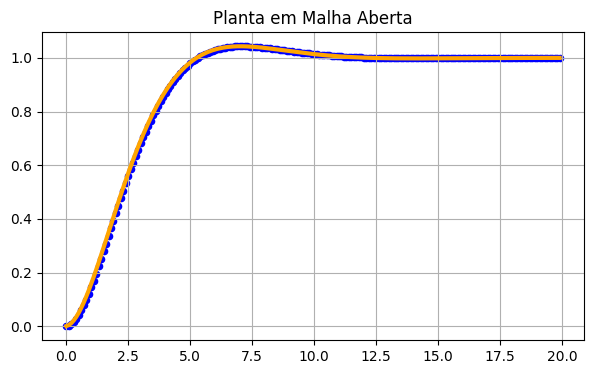

In [103]:
time = np.arange(0, 20, dt)
time, continuous = ctl.step_response(C, T=time)
time, digital    = ctl.step_response(C_z, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, continuous, color='blue', s=20, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **printDigital**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

- Estados anteriores
    - Y[0], Y[1], Y[2] ... se referem aos estados $Y_n$ (saída atual), $Y_{n-1}$ (penúltima saída), $Y_{n-2}$ (antipenúltima saída)

In [104]:
def getFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    num = [float(val) for val in num]
    den = [float(val) for val in den]
    return (num, den) 


num, den = getFraction(C_z)
print(f'num -> xSize={len(num)}')
print(f'den -> ySize={len(den)}')

num -> xSize=3
den -> ySize=3


In [ ]:
def printDigital(num, den):
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn[{i}]*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn[{i}]*({-1*den[i]:.6f}) + '
    
    out = out.replace('X_n0', 'X_n')[:-3]
    print('Y[0] =', out)
    pyperclip.copy(out + ';')


printDigital(num, den)

Y[0] = Xn[0]*(0.000944) + Xn[1]*(0.001888) + Xn[2]*(0.000944) + Yn[1]*(1.911226) + Yn[2]*(-0.915003)


In [106]:
class Controller:
    def __init__(self, num, den, dt=0.05, bounds=None):
        self.bounds = bounds
        self.num = num
        self.den = den
        self.dt = dt
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += -1*self.Yn[i]*self.den[i]

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        output = self.compute()
        
        if self.bounds and output < self.bounds[0]:
            output = self.bounds[0]
        
        if self.bounds and output > self.bounds[1]:
            output = self.bounds[1]
        
        self.Yn[0] = output
        return self.Yn[0]
    
    def control(self, input, setpoint):
        return self.update(setpoint - input)
    
    def reset(self, val=0):
        self.Xn = val*np.ones_like(self.num)
        self.Yn = val*np.ones_like(self.den)
    

filter = Controller(num, den, dt)

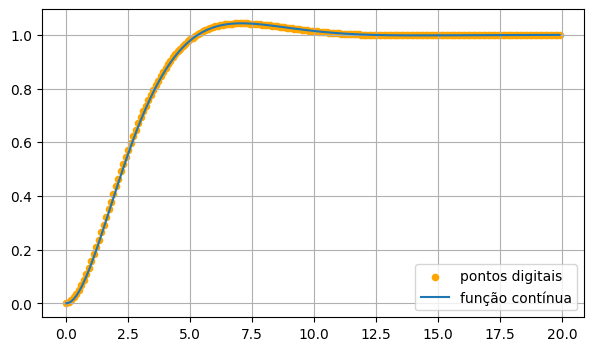

In [107]:
digital = [filter.update(1) for t in time]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# SIMULANDO SISTEMA

In [108]:
df = pd.read_csv('DataBase.csv')
df.head()

,time,input
0,110.062839,4034.0
1,110.141765,4045.0
2,110.221532,4059.0
3,110.301835,4044.0
4,110.382143,4043.0


In [109]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue
        
        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', dt)
df

,time,input
0,0.0,4034.0
1,0.1,4045.0
2,0.2,4059.0
3,0.3,4044.0
4,0.4,4043.0
...,...,...
1395,139.5,4095.0
1396,139.6,4095.0
1397,139.7,4095.0
1398,139.8,4095.0


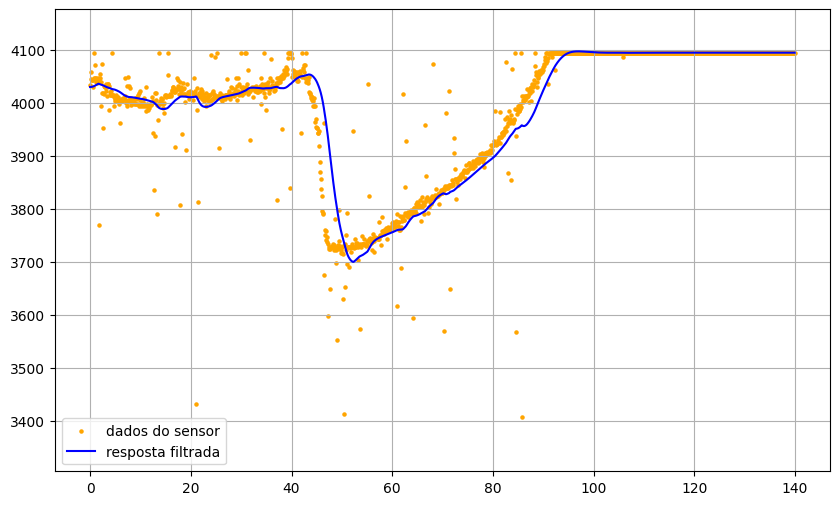

In [110]:
filter.reset(df.input[df.time < 3.0].mean())

xData  = df.time.values
yData  = df.input.values
yModel = [filter.update(val) for val in yData]

plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, s=5, color='orange', label='dados do sensor')
plt.plot(xData, yModel, color='blue', label='resposta filtrada')
plt.ylim(yData.min()*0.97, yData.max()*1.02)
plt.legend(), plt.grid()
plt.show()